**Classificação de Pátios com Machine Learning – Projeto MotoSync
Neste notebook, vamos aplicar técnicas de Machine Learning para classificar pátios operacionais do sistema MotoSync com base em seus padrões de uso. O objetivo é categorizar os pátios em três perfis:**

*alta_rotatividade* = Alta entrada e saída de motos

*baixa_utilizacao* = Baixa entrada e saída de motos

*gargalo* = Alta entrada e Baixa saída de motos

Utilizaremos um modelo de Random Forest para realizar a classificação a partir de dados simulados que incluem informações como número de vagas, movimentações diárias, ocupação média e tempo médio de uso das vagas.

In [ ]:
# Imports necessários

# Importa o pandas para manipulação de dados em formato de tabela (DataFrames)
import pandas as pd

# Importa o seaborn para visualizações estatísticas mais elegantes e informativas
import seaborn as sns

# Importa o matplotlib para criação de gráficos personalizados
import matplotlib.pyplot as plt

# Função do scikit-learn para dividir os dados entre treino e teste
from sklearn.model_selection import train_test_split

# Utilizado para padronizar (normalizar) os dados numéricos, deixando-os com média 0 e desvio padrão 1
from sklearn.preprocessing import StandardScaler

# Modelo de Machine Learning usado para classificação baseado em múltiplas árvores de decisão
from sklearn.ensemble import RandomForestClassifier

# Ferramentas para avaliar o modelo: matriz de confusão e relatório com precisão, recall e F1-score
from sklearn.metrics import classification_report, confusion_matrix

# Calcula a acurácia do modelo, ou seja, a porcentagem de previsões corretas
from sklearn.metrics import accuracy_score

In [ ]:
# Carregando os dados

df = pd.read_csv("motosync_patios_dataset.csv")

In [ ]:
# Visualizando os 5 primeiras linhas do dataset

df.head()

,id_patio,qtd_vagas_total,qtd_movimentacoes_diarias,ocupacao_media_pct,tempo_medio_ocupacao_min,tipo_patio
0,1,61,93,97.74,130.95,baixa_utilizacao
1,2,24,75,97.00,566.06,baixa_utilizacao
2,3,81,13,40.14,573.74,alta_rotatividade
3,4,70,92,59.78,551.47,gargalo
4,5,30,133,44.07,240.99,alta_rotatividade


In [ ]:
# Utilizamos o "df.info()" para identificarmos os tipos dos dados dentro do dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_patio                   100 non-null    int64  
 1   qtd_vagas_total            100 non-null    int64  
 2   qtd_movimentacoes_diarias  100 non-null    int64  
 3   ocupacao_media_pct         100 non-null    float64
 4   tempo_medio_ocupacao_min   100 non-null    float64
 5   tipo_patio                 100 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 4.8+ KB


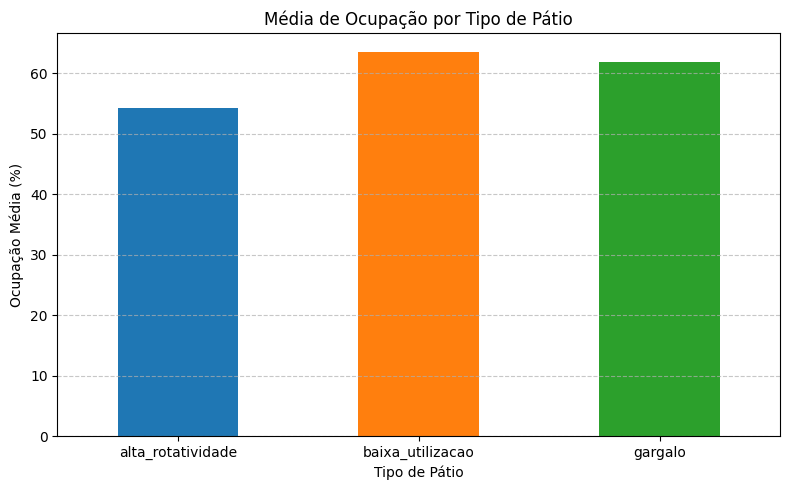

In [ ]:
# Ocupação Média por Tipo de Pátio

# Agrupamento por tipo de pátio e média de ocupação
df_grouped = df.groupby("tipo_patio")["ocupacao_media_pct"].mean()

# Este gráfico mostra a média da ocupação (%) para cada tipo de pátio.
# Ele ajuda a visualizar quais categorias tendem a estar mais cheias ou vazias, o que pode indicar gargalos ou subutilização de recursos.
plt.figure(figsize=(8, 5))
df_grouped.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Média de Ocupação por Tipo de Pátio")
plt.ylabel("Ocupação Média (%)")
plt.xlabel("Tipo de Pátio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Como vimos no bloco acima, os dados de "alta_rotatividade", "baixa_rotatividade" e "gargalo" não estão representando exatamente o que deveriam.**

Com isso, podemos fazer um tratamento com esses dados:

In [ ]:
# Função para rotular os pátios com base nos dados reais
def rotular_patio(row):
    if row["ocupacao_media_pct"] > 80 and row["tempo_medio_ocupacao_min"] > 400:
        return "gargalo"
    elif row["qtd_movimentacoes_diarias"] > 120 and row["tempo_medio_ocupacao_min"] < 300:
        return "alta_rotatividade"
    else:
        return "baixa_utilizacao"

# Aplicando a lógica ao dataframe
df["tipo_patio"] = df.apply(rotular_patio, axis=1)


<ipython-input-10-28b4a48dc513>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="tipo_patio", y="qtd_movimentacoes_diarias", data=df, palette="Set2")


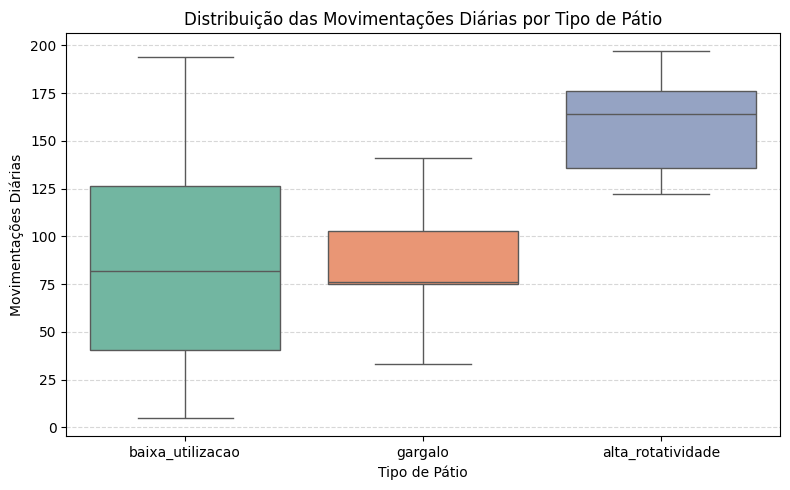

In [ ]:
# Distribuição das Movimentações Diárias por Tipo de Pátio

# Mostra a variação das movimentações diárias em cada tipo de pátio, destacando a mediana, os extremos e possíveis outliers.
plt.figure(figsize=(8, 5))
sns.boxplot(x="tipo_patio", y="qtd_movimentacoes_diarias", data=df, palette="Set2")
plt.title("Distribuição das Movimentações Diárias por Tipo de Pátio")
plt.xlabel("Tipo de Pátio")
plt.ylabel("Movimentações Diárias")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

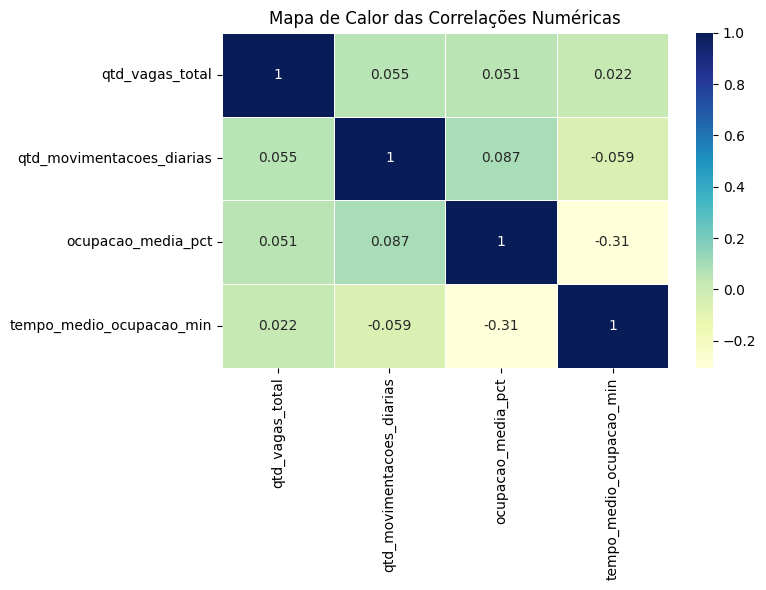

In [ ]:
# Heatmap das correlações numéricas
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["id_patio"]).select_dtypes(include="number").corr(),
            annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Mapa de Calor das Correlações Numéricas")
plt.tight_layout()
plt.show()

**Agora sim!!**

Nesses trechos acima podemos ver que o tratamento deu resultados esperados, a partir disso, vamos continuar com o modelo


**Pré-processamento**

*   X contém as colunas com dados operacionais.

*   y é a label: o tipo de pátio.

*   Fazemos uma divisão 80/20 com stratify para manter a proporção das classes.

*   Usamos StandardScaler para normalizar os dados numéricos, o que ajuda muitos modelos a performar melhor.













In [ ]:
# Separando features e rótulo
X = df.drop(columns=["id_patio", "tipo_patio"])
y = df["tipo_patio"]

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Treinamento com Random Forest**

*   O RandomForestClassifier é robusto, lida bem com outliers e não exige tanto ajuste fino.

*   Aqui ele é treinado com 100 árvores (estimators).



In [ ]:
# Treinamento do modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

**Avaliação do Modelo**

*   confusion_matrix: mostra como as classes foram classificadas corretamente ou não.


*   classification_report: mostra métricas como precisão, recall e F1-score por classe.



In [ ]:
# Previsão no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliação
accuracy = accuracy_score(y_test, y_pred) # Exibe a acurácia do modelo em porcentagem
print(f"Acurácia do modelo: {accuracy * 100:.2f}%")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia do modelo: 95.00%
[[ 4  0  0]
 [ 0 15  0]
 [ 0  1  0]]
                   precision    recall  f1-score   support

alta_rotatividade       1.00      1.00      1.00         4
 baixa_utilizacao       0.94      1.00      0.97        15
          gargalo       0.00      0.00      0.00         1

         accuracy                           0.95        20
        macro avg       0.65      0.67      0.66        20
     weighted avg       0.90      0.95      0.93        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**CONLUSÃO**

Com base nos dados operacionais simulados do sistema MotoSync, foi desenvolvido um modelo de classificação capaz de prever o tipo de pátio com base em variáveis como número de vagas, ocupação média, movimentações diárias e tempo médio de uso das vagas. Após o tratamento dos dados e a correção da lógica de categorização dos pátios, o modelo treinado com Random Forest atingiu uma acurácia de *95%*, demonstrando boa capacidade de generalização mesmo em um cenário simplificado.

A reclassificação dos rótulos usando regras baseadas em comportamento real dos pátios foi fundamental para tornar os resultados coerentes e confiáveis. Os gráficos atualizados refletiram corretamente o padrão esperado de cada tipo de pátio, o que reforça a importância da qualidade dos dados no processo de aprendizado de máquina.

Este experimento mostrou que é possível aplicar inteligência artificial de forma eficaz para otimizar a gestão de pátios, e que o modelo pode ser facilmente adaptado e aprimorado com dados reais coletados por sensores. Com isso, o MotoSync pode evoluir para um sistema preditivo que apoia decisões logísticas com base em dados e aprendizado contínuo.